# FBI UCR Hate Crime Data

This data is taken from the FBI's Uniform Crime Reporting Statistics reports (https://ucr.fbi.gov/hate-crimes/2015/home). The data is available for each state and year back to 1996, but is only available in Excel format back to 2006. Prior years are PDF reports.  

First we need to pull all the data, clean it up, and combine it into one dataframe. Each report has the same format which makes things a bit easier. The data is presented in a tabular form, so we'll have to transform the final dataframe once everything is combined. 

In [211]:
import pandas as pd
import urllib
import numpy as np

# Urls for each of the files
urllist = [r'https://ucr.fbi.gov/hate-crime/2015/tables-and-data-declarations/13tabledatadecpdf/table_13_hate_crime_incidents_per_bias_motivation_and_quarter_by_state_and_agency_2015.xls', 
           r'https://ucr.fbi.gov/hate-crime/2014/tables/table-13/table_13_hate_crime_incidents_per_bias_motivation_and_quarter_by_state_and_agency_2014.xls', 
           r'https://ucr.fbi.gov/hate-crime/2013/tables/13tabledatadecpdf/table_13_hate_crime_incidents_per_bias_motivation_and_quarter_by_state_and_agency_2013.xls', 
           r'https://ucr.fbi.gov/hate-crime/2012/tables-and-data-declarations/13tabledatadecpdf/table_13_hate_crime_incidents_per_bias_motivation_and_quarter_by_state_and_agency_2012.xls', 
           r'https://ucr.fbi.gov/hate-crime/2011/tables/table-13-2', 
           r'https://ucr.fbi.gov/hate-crime/2010/tables/table-13-hate-crime-incidents-per-bias-motivation-and-quarter-by-state-and-agency-2010', 
           r'https://www2.fbi.gov/ucr/hc2009/data/documents/table13.xls', 
           r'https://www2.fbi.gov/ucr/hc2008/data/documents/table13.xls', 
           r'https://www2.fbi.gov/ucr/hc2007/hatecrimetables/table13.xls', 
           r'https://www2.fbi.gov/ucr/hc2006/excels/table13.xls']

# Set user agent for urllib
opener = urllib.request.FancyURLopener({}) 
opener.version = 'Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/47.0.2526.69 Safari/537.36'

# Download and save a copy of each excel file
a = 2015
for i in urllist:
    opener.retrieve(i, str(a)+'.xls')
    a -= 1

# Open and process each file, add dataframe to list, then combine into single dataframe
df_list = []

for i in range(2006, 2016):  
    # The format is slightly different for various years so we need to change the rows being skipped
    if i < 2011:
        df = pd.read_excel(str(i)+'.xls', skiprows=[0,1,2])
        df.rename(columns = {'Unnamed: 0':'State', 'Unnamed: 1': 'Location Type', 'Unnamed: 2':'Location Name', 'Unnamed: 9':'Population', 'Unnamed: 12':'Population', 'Unnamed: 13':'Population', 'Unnamed: 14':'Population'}, inplace=True)
    elif i == 2011: 
        df = pd.read_excel(str(i)+'.xls', skiprows=[0,1,2,3])
        df.rename(columns = {'Unnamed: 0':'State', 'Unnamed: 1': 'Location Type', 'Unnamed: 2':'Location Name', 'Unnamed: 9':'Population', 'Unnamed: 12':'Population', 'Unnamed: 13':'Population', 'Unnamed: 14':'Population'}, inplace=True)
    else: 
        df = pd.read_excel(str(i)+'.xls', skiprows=[0,1,2,3,4])
        df.rename(columns = {'Unnamed: 0':'State', 'Unnamed: 1': 'Location Type', 'Unnamed: 2':'Location Name', 'Unnamed: 9':'Population', 'Unnamed: 12':'Population', 'Unnamed: 13':'Population', 'Unnamed: 14':'Population'}, inplace=True)
    
    # Drop the total field, forward fill NaNs for Location Type, fill count NaNs with 0, drop top line totals, add year
    df.dropna(axis=1, how='all', inplace=True)
    df['State'].fillna(method='ffill', inplace=True)
    df['Location Type'].fillna(method='ffill', inplace=True)
    df.drop(df.index[df['Location Name'].isnull()==True], inplace=True)
    df['Year'] = i
    df['Location Name'] = df['Location Name'].str.upper()
    df['Location Type'] = df['Location Type'].str.upper()
    df['State'] =  df['State'].str.upper()
    if i == 2006: 
        df.drop(labels='Unnamed: 3', axis=1, inplace=True) 
    
    df_list.append(df)

# Combine into single dataframe, fill Nans
crime_data = pd.concat([i for i in df_list])
crime_data.fillna(value=0.0, inplace=True)

Now that we have everything in a singular dataframe, we can finally start exploring the data (http://stackoverflow.com/questions/33282368/plotting-a-2d-heatmap-with-matplotlib).

In [212]:
# First pivot to sum by state, year
p1 = crime_data.pivot_table(index=['State', 'Year'], aggfunc=np.sum)
p1['Sum'] = p1[['Disability', 'Ethnicity', 'Gender\nIdentity', 'Gender Identity', 'Race', 
                'Race/\nEthnicity/\nAncestry', 'Religion', 'Sexual\norientation']].sum(axis=1)
p1.reset_index(inplace=True)

# Second pivot to get years into columns, state as index
p2 = p1.pivot_table(index='State', columns='Year', values='Sum')
p2.fillna(value=0.0, inplace=True)

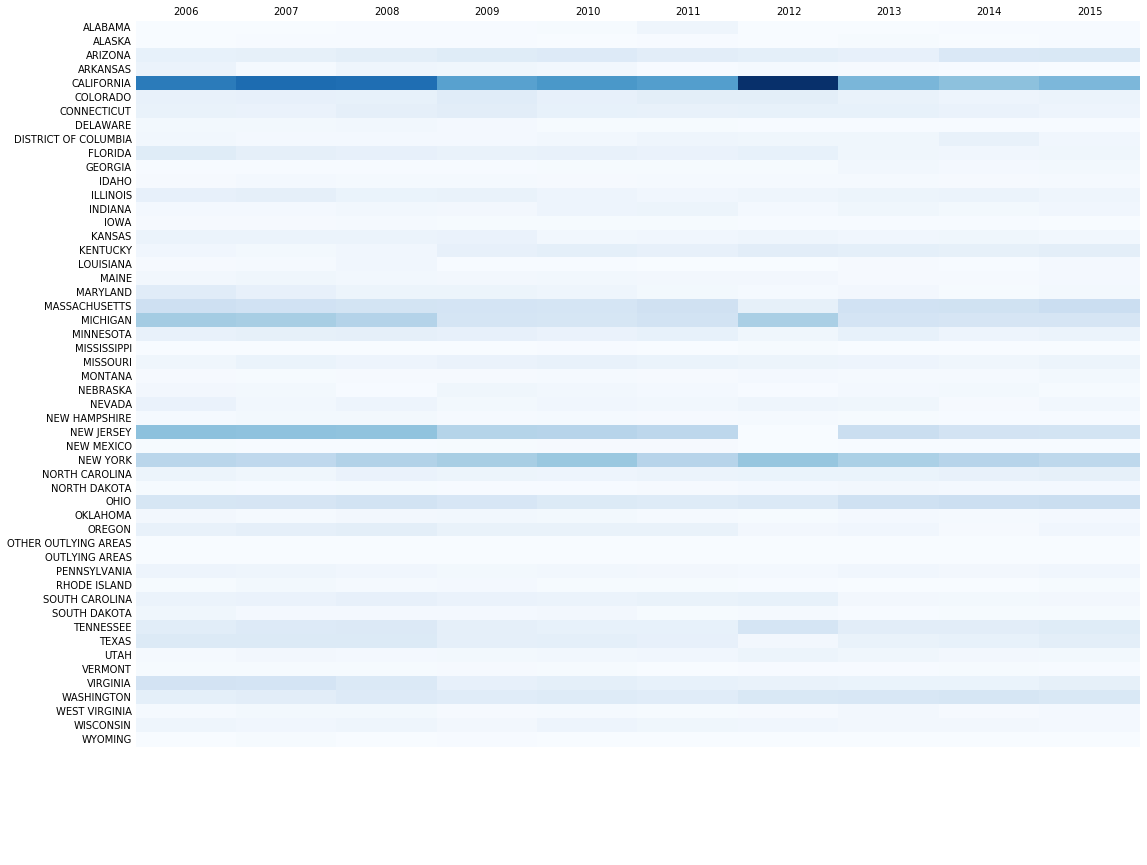

In [228]:
%matplotlib inline
import matplotlib.pyplot as plt

# Set up plots 
fig, sub = plt.subplots()

# Format
fig = plt.gcf()
fig.set_size_inches(18,15)
sub.set_frame_on(False)
sub.invert_yaxis()
sub.xaxis.tick_top()
sub.grid(False)

# Plot data and label axis
sub.pcolor(p2, cmap=plt.cm.Blues)
sub.set_yticks(np.arange(p2.shape[0])+0.5, minor=False)
sub.set_xticks(np.arange(p2.shape[1])+0.5, minor=False)
sub.set_xticklabels(p2.columns.tolist()) 
sub.set_yticklabels(p2.index.tolist(), minor=False)

for t in sub.xaxis.get_major_ticks(): 
    t.tick1On = False 
    t.tick2On = False 
for t in sub.yaxis.get_major_ticks(): 
    t.tick1On = False 
    t.tick2On = False  